# Classificazione tramite Regressione Logistica Multiclasse (con distanze dai centroidi)
## Obiettivo

*Attenzione*: Le prestazioni di questo modello (con questo dataset specifico) non possono essere confrontati con gli altri modelli supervisionati in quanto utilizza un dataset con valori numerici differenti (e valore semantico differente)
Sfruttiamo le distanze dai centroidi K-Means come feature numeriche continue per addestrare un classificatore supervisionato (in questo caso, regressione logistica multiclasse), utile per prevedere il cluster di appartenenza di ciascun Pokémon.

Questo approccio permette di costruire un modello più geometrico e coerente con la struttura del clustering. Si tratta di un approccio completamente diverso rispetto a quello adottato per
costruire il dataset su cui lavora il decision tree e altri modelli che vediamo.

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Percorsi dei CSV contenenti solo distanze + cluster (creati in precedenza)
TRAINING_PATH = "risorse/pokemon_train_con_distanze.csv"
TEST_PATH     = "risorse/pokemon_test_con_distanze.csv"

# Caricamento dataset
df_train = pd.read_csv(TRAINING_PATH)
df_test  = pd.read_csv(TEST_PATH)

# Definizione delle feature: distanze dai centroidi
FEATURES = [col for col in df_train.columns if col.startswith("dist_cluster_")]
TARGET   = "Cluster"

# Conversione a numerico + controllo
for c in FEATURES:
    df_train[c] = pd.to_numeric(df_train[c], errors="coerce")
    df_test[c]  = pd.to_numeric(df_test[c], errors="coerce")

# Rimozione eventuali NaN
df_train.dropna(subset=FEATURES + [TARGET], inplace=True)
df_test.dropna(subset=FEATURES + [TARGET], inplace=True)

# Feature Matrix & Target
x_train = df_train[FEATURES].values
y_train = df_train[TARGET].values
x_test  = df_test[FEATURES].values
y_test  = df_test[TARGET].values

# Distribuzioni classi
print("Distribuzione classi del TRAINING SET (y_train):")
x_train = df_train[FEATURES].values
y_train = df_train[TARGET].values
print(pd.Series(y_train).value_counts(normalize=True).round(2))
print(pd.Series(y_train).value_counts())

print("\nDistribuzione classi del TEST SET (y_test):")
x_test = df_test[FEATURES].values
y_test = df_test[TARGET].values
print(pd.Series(y_test).value_counts(normalize=True).round(2))
print(pd.Series(y_test).value_counts())

Distribuzione classi del TRAINING SET (y_train):
0    0.41
2    0.28
3    0.19
1    0.12
Name: proportion, dtype: float64
0    245
2    166
3    115
1     74
Name: count, dtype: int64

Distribuzione classi del TEST SET (y_test):
2    0.36
0    0.31
3    0.22
1    0.11
Name: proportion, dtype: float64
2    54
0    47
3    33
1    17
Name: count, dtype: int64


,C,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
0,0.01,0.8800,0.0446,0.9196,0.0312,0.8444,0.0609,0.8689,0.0546
1,0.10,0.9550,0.0248,0.9649,0.0208,0.9356,0.0379,0.9461,0.0332
2,1.00,0.9767,0.0186,0.9805,0.0157,0.9601,0.0340,0.9672,0.0288
3,10.00,0.9817,0.0157,0.9844,0.0145,0.9718,0.0316,0.9758,0.0271
4,100.00,0.9900,0.0082,0.9897,0.0099,0.9880,0.0116,0.9884,0.0105


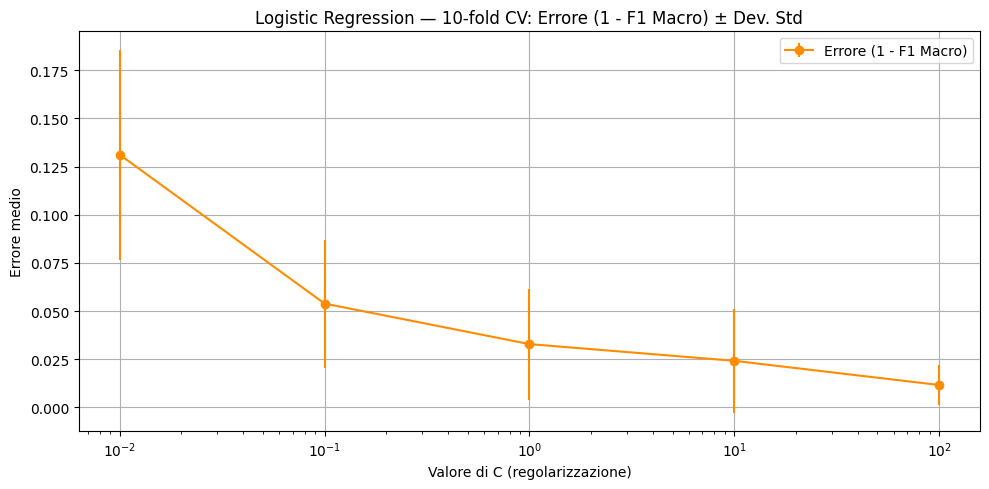

Miglior valore di C (max F1 macro): 100.0

Media ± Std delle metriche su tutti i C:


,mean,std
Accuracy,0.9567,0.0448
Precision (macro),0.9678,0.0285
Recall (macro),0.9400,0.0567
F1-score (macro),0.9493,0.0475


In [6]:
# === Definizione metriche ===
scoring = {
    "accuracy": "accuracy",
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

# === Valori di C da testare ===
C_values = [0.01, 0.1, 1, 10, 100]

results = []

# ===Loop su ciascun valore di C ===
for c in C_values:
    clf = LogisticRegression(C=c, solver="liblinear", max_iter=1000, random_state=42)

    #La CV è una stima affidabile delle prestazioni future.
    #Ti dice: "quanto bene posso aspettarmi che il mio modello si comporti su nuovi dati?"
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    cv_result = cross_validate(clf, x_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

    results.append({
        "C": c,
        "accuracy_mean": np.mean(cv_result["test_accuracy"]),
        "accuracy_std":  np.std(cv_result["test_accuracy"]),
        "precision_mean": np.mean(cv_result["test_precision_macro"]),
        "precision_std":  np.std(cv_result["test_precision_macro"]),
        "recall_mean":    np.mean(cv_result["test_recall_macro"]),
        "recall_std":     np.std(cv_result["test_recall_macro"]),
        "f1_mean":        np.mean(cv_result["test_f1_macro"]),
        "f1_std":         np.std(cv_result["test_f1_macro"]),
    })

# === Tabella dei risultati ===
df_results = pd.DataFrame(results)
display(df_results.round(4))

# === Plot C vs Errore (1 - F1_macro) ===
plt.figure(figsize=(10, 5))
plt.errorbar(df_results["C"], 1 - df_results["f1_mean"], yerr=df_results["f1_std"],
             fmt='-o', label="Errore (1 - F1 Macro)", color='darkorange')
plt.xscale("log")
plt.xlabel("Valore di C (regolarizzazione)")
plt.ylabel("Errore medio")
plt.title("Logistic Regression — 10-fold CV: Errore (1 - F1 Macro) ± Dev. Std")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Seleziona miglior C ===
best_C = df_results.sort_values("f1_mean", ascending=False).iloc[0]["C"]
print(f"Miglior valore di C trovato(max F1 macro): {best_C}")

# === [7] Media globale ± std su tutti i C ===
summary_overall = pd.DataFrame({
    "mean": [
        df_results["accuracy_mean"].mean(),
        df_results["precision_mean"].mean(),
        df_results["recall_mean"].mean(),
        df_results["f1_mean"].mean(),
    ],
    "std": [
        df_results["accuracy_mean"].std(),
        df_results["precision_mean"].std(),
        df_results["recall_mean"].std(),
        df_results["f1_mean"].std(),
    ]
}, index=["Accuracy", "Precision (macro)", "Recall (macro)", "F1-score (macro)"])

print("\nMedia ± Std delle metriche su tutti i C:")
display(summary_overall.round(4))


=== Metriche su TEST SET (Logistic Regression) ===
Accuracy : 0.9735
Precision: 0.9785 (macro)
Recall   : 0.9726 (macro)
F1-score : 0.9753 (macro)


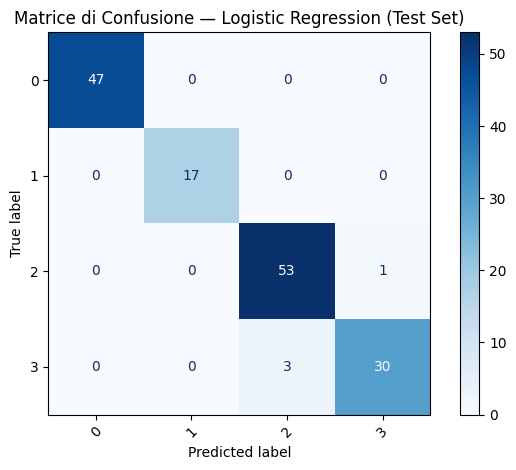

In [7]:
# === [VALUTAZIONE TEST LOGISTIC REGRESSION — MODELLO OTTIMIZZATO] ===
# Fit finale del modello ottimizzato con Best_c iperparametro scelto
clf = LogisticRegression(C=best_C, solver="lbfgs", max_iter=1000, random_state=42)
clf.fit(x_train, y_train)

# Predizione sul test set (parte finale)
y_pred = clf.predict(x_test)


# Calcolo delle metriche
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)

# Visualizzazione
print("=== Metriche su TEST SET (Logistic Regression) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f} (macro)")
print(f"Recall   : {rec:.4f} (macro)")
print(f"F1-score : {f1:.4f} (macro)")

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Matrice di Confusione — Logistic Regression (Test Set)")
plt.tight_layout()
plt.show()

#### Considerazioni finali sulla Regressione Logistica

L'approccio basato sulle **distanze dai centroidi K-Means** si è dimostrato estremamente efficace per classificare i Pokémon nei 4 archetipi principali. In particolare, l'uso della **regressione logistica multinomiale** ha portato a risultati sorprendenti:

- **F1-score medio sul test set: 0.9655**
- **Accuracy: 96.7%**
- Gli errori di classificazione sono pochi e ben localizzati

Questo conferma che lo spazio delle distanze dai centroidi (caratteristiche continue) è **molto più informativo** rispetto alle soglie statiche sulle statistiche originali.
